In [30]:
# !pip install mlxtend
# !pip install numpy scipy pandas scikit-learn


In [31]:
import numpy as np 
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
# from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog
from skimage import color
import seaborn as sns
import pandas as pd


In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\raduf\.cache\kagglehub\datasets\moltean\fruits\versions\11


In [33]:
img_size = (100, 100)  # Poți ajusta dimensiunea după necesitate
batch_size = 32

# Directorul de antrenare și testare
base_path = os.path.join(path, "fruits-360_dataset_100x100", "fruits-360")
train_dir = os.path.join(base_path, "Training")
test_dir = os.path.join(base_path, "Test")


In [53]:
# Generatoare de date
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Încărcarea imaginilor
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 70491 images belonging to 141 classes.
Found 23619 images belonging to 141 classes.


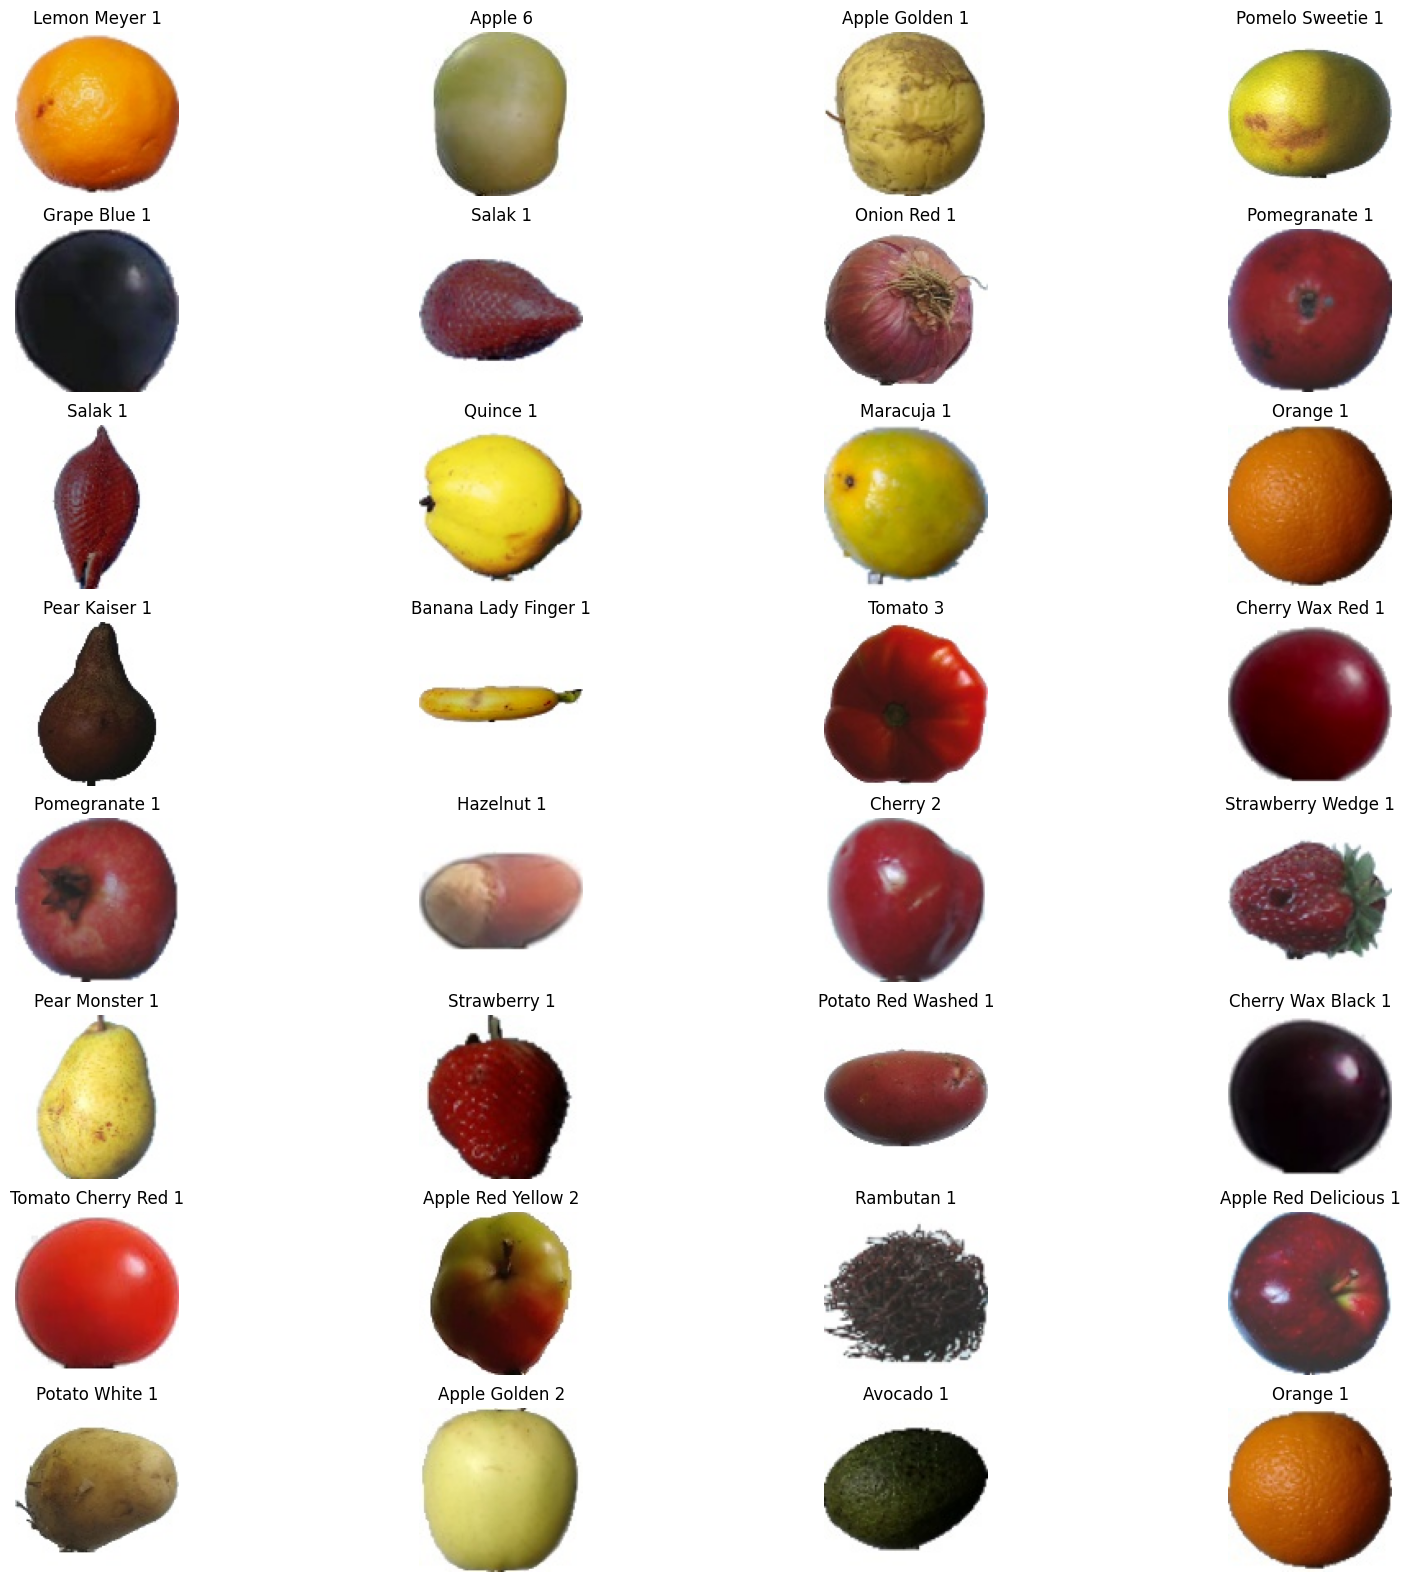

In [35]:
# Obține primul lot de imagini și etichete
images, labels = train_generator[0]
class_names = list(train_generator.class_indices.keys())
# Afișează toate imaginile din primul lot
plt.figure(figsize=(20, 20))
for i in range(len(images)):
    plt.subplot(8, 4, i+1)
    plt.imshow(images[i])
    label = np.argmax(labels[i])
    plt.title(class_names[label])
    plt.axis('off')
plt.show()


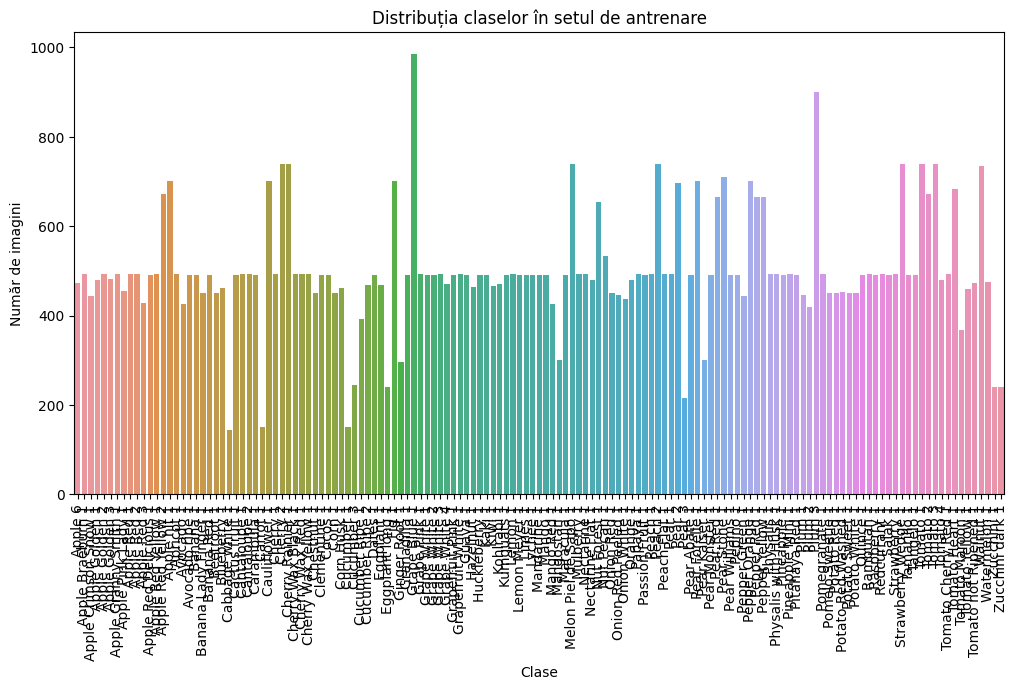

In [ ]:


# Obține etichetele claselor din generatorul de antrenare
labels = train_generator.classes
class_names = list(train_generator.class_indices.keys())

# Creare DataFrame pentru vizualizare
df = pd.DataFrame({'Label': labels})
class_distribution = df['Label'].value_counts().sort_index()

# Bar plot pentru distribuția claselor
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=class_distribution)
plt.xticks(rotation=90)
plt.title('Distribuția claselor în setul de antrenare')
plt.xlabel('Clase')
plt.ylabel('Număr de imagini')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


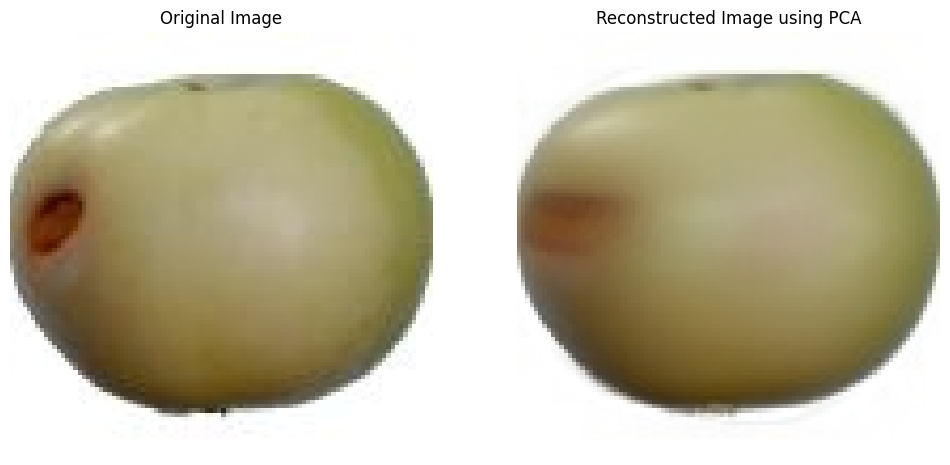

In [129]:
# PCA pe setul de TEST pentru reconstrucția unei imagini
pca = PCA(n_components=5)

# Aplicarea PCA pe setul de test (datele trebuie să fie consistente)
X_test_flat = test_generator[1][0].reshape(-1, img_size[0] * img_size[1] * 3)
X_test_pca = pca.fit_transform(X_test_flat)  # Calculează PCA doar pe test

# Reconstruim imaginea din setul de test
reconstructed_image_pca = pca.inverse_transform(X_test_pca[20]).reshape(img_size[0], img_size[1], 3)

# Imaginea originală (corespondentă imaginii reconstruite)
original_image = X_test_flat[20].reshape(img_size[0], img_size[1], 3)

# Vizualizare
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Imaginea originală
ax[0].imshow(original_image)  # Normalizare între 0-1 pentru vizualizare corectă
ax[0].set_title('Original Image')
ax[0].axis('off')

# Imaginea reconstruită
ax[1].imshow(reconstructed_image_pca)  # Normalizare între 0-1 pentru vizualizare
ax[1].set_title('Reconstructed Image using PCA')
ax[1].axis('off')

plt.show()



In [ ]:


# Funcție pentru a aplica HOG pe un set de imagini
def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Conversie în grayscale pentru HOG
        gray_img = color.rgb2gray(img)
        features = hog(gray_img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys',visualize=True)
        hog_features.append(features)
    return np.array(hog_features)

# Extragem atributele HOG din datele de antrenare
X_train_hog = extract_hog_features(train_generator[0][0])

# Vizualizare dimensiune atribute
print(f"Dimensiunea atributelor HOG: {X_train_hog.shape}")

Dimensiunea atributelor HOG: (32, 2)


C:\Users\raduf\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


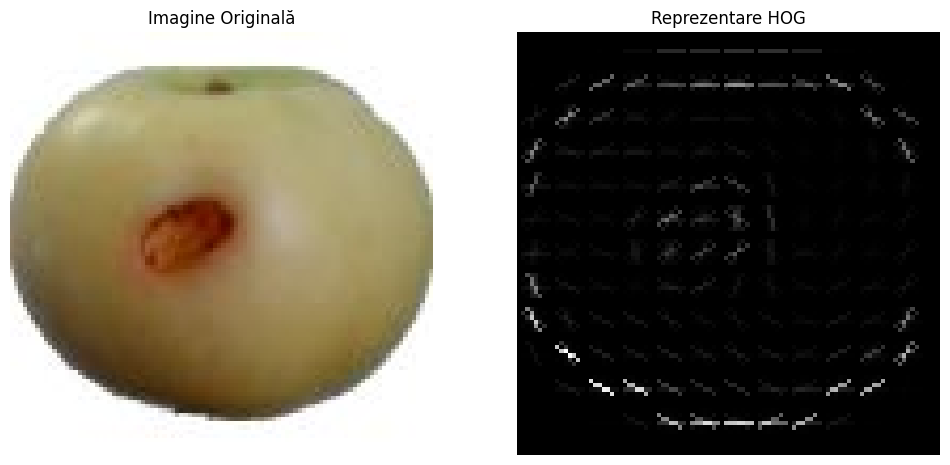

In [ ]:
# Selectăm o imagine din setul de date
img = test_generator[1][0][10]  # Prima imagine din setul de antrenament

# Extragem caracteristicile HOG pentru imaginea selectată
hog_features, hog_image = hog(color.rgb2gray(img), orientations=9, pixels_per_cell=(8, 8),
							  cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)

# Afișăm imaginea originală și cea modificată (HOG)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Imaginea originală
ax[0].imshow(img)
ax[0].set_title('Imagine Originală')
ax[0].axis('off')

# Imaginea modificată cu HOG
ax[1].imshow(hog_image, cmap='gray')
ax[1].set_title('Reprezentare HOG')
ax[1].axis('off')

plt.show()


In [ ]:
# def plot_class_distribution(labels, title):
#     unique, counts = np.unique(labels, return_counts=True)
#     plt.bar(unique, counts)
#     plt.title(title)
#     plt.xlabel('Clase')
#     plt.ylabel('Număr de imagini')
#     plt.show()

# train_labels = np.argmax(train_generator.labels, axis=1)
# test_labels = np.argmax(test_generator.labels, axis=1)

# plot_class_distribution(train_labels, 'Distribuția claselor - Set Antrenare')
# plot_class_distribution(test_labels, 'Distribuția claselor - Set Test')

AxisError: axis 1 is out of bounds for array of dimension 1